In [475]:
from scipy import stats
import os
import sys
sys.path.append('..')
import seaborn as sns
from set_global_params import raw_tracking_path, processed_data_path, bias_path, change_over_time_mice, fig4_plotting_colours
from utils.post_processing_utils import get_all_experimental_records
from utils.plotting_visuals import makes_plots_pretty
from matplotlib.ticker import MaxNLocator
import statsmodels.api as sm
from utils.plotting import output_significance_stars_from_pval, calculate_error_bars
from utils.plotting_visuals import makes_plots_pretty

In [358]:
def shift_respecting_index(vals_to_shift, shift_size):
    """
    Shifts a pandas df column by shift_size indices
    but if there is a discontinuity in the index,
    replaces the shifted index with nan
    """
    shifted_vals = vals_to_shift.shift(periods=shift_size)

    # Detect discontinuities in the index
    trial_num_diff = vals_to_shift.index.to_series().diff().fillna(shift_size)

    # Identify where the shift should result in NaN due to discontinuities
    discontinuities = trial_num_diff > shift_size
    shifted_vals[discontinuities] = np.nan

    
    return shifted_vals


In [367]:
def perform_single_lag_regression(all_session_data, lag):
    all_session_data[f'choice_t_minus_{lag}'] = shift_respecting_index(all_session_data['choice'], lag)
    all_session_data[f'stim_t_minus_{lag}'] = shift_respecting_index(all_session_data['Trial type'], lag)
    all_session_data[f'stim_t_minus{lag}_match'] = (all_session_data[f'stim_t_minus_{lag}'] == all_session_data['Trial type'])
    # Define the dependent variable (dopamine response size)
    test_var = f'choice_t_minus_{lag}'


    contra_trials = all_session_data[(all_session_data['trial_type'] == 'contra_data')
                                     & (all_session_data[f'stim_t_minus{lag}_match'] == True)
                                    & (all_session_data['First choice correct'] == 1)]
    

    
    df = contra_trials[['APE_peaks', test_var]].copy()
    df.loc[:, test_var] = df[test_var].astype(float)
    df.loc[:, 'APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)

    df.loc[:, 'APE_peaks'] = df['APE_peaks'].astype(float)
    df = df.dropna().reset_index(drop=True)


    y = df['APE_peaks'].astype(float)
    X = df[test_var]
    X = sm.add_constant(X)
    # Fit the regression model
    model = sm.OLS(y, X).fit()
    return model.params[1:], model.pvalues[1:], all_session_data

In [374]:
def regress_previous_choice_same_stim_against_DA(mice, num_lags=5):
    num_mice = len(mice)
    coefs = np.zeros([num_mice, num_lags])
    pvals = np.zeros([num_mice, num_lags])
    for m, mouse in enumerate(mice):
        bias_file = os.path.join(bias_path, 'pre_processing_bias_{}.pkl'.format(mouse))
        all_session_data = pd.read_pickle(bias_file).drop_duplicates(subset='actual trial nums', keep='first').set_index('actual trial nums')

        contra_side = all_session_data[(all_session_data['trial_type'] == 'contra_data') & (all_session_data['First choice correct'] == 1)]['First response'].unique()[0]
        if contra_side == 1:
            ipsi_contra_map = {1: 'contra', 2: 'ipsi'} 
        else:
            ipsi_contra_map = {1: 'ipsi', 2: 'contra'}
        all_session_data['choice'] = all_session_data['First response'].map(ipsi_contra_map)

        # Map 'choice' column to 1 and 0
        all_session_data['choice'] = all_session_data['choice'].map({'contra': 1, 'ipsi': 0})

        for lag in range(1, num_lags + 1):
            coefs[m, lag-1], pvals[m, lag-1], _ = perform_single_lag_regression(all_session_data, lag)
    return coefs, pvals

In [375]:
def plot_sig_stars_multilag(coefs, color, axs):
    second_order_coefs, second_order_pvals = test_for_coef_trend_against_zero_mulit_lag(coefs)
    for lag_num in range(0, len(second_order_coefs)):
        sig_stars = output_significance_stars_from_pval(second_order_pvals[lag_num])
        if sig_stars != 'n.s.':
            if second_order_coefs[lag_num] >= 0:
                y = 0.3
            else:
                y=-0.45
            axs.text(lag_num + 1, y, sig_stars, ha='center', fontsize=12, color=color)
            

In [376]:
def test_for_coef_trend_against_zero_mulit_lag(coefs):
    pvals = []
    slopes = []
    for lag_num in range(0, coefs.shape[1]):
        test = stats.ttest_1samp(coefs.T[lag_num], 0)
        pvals.append(test.pvalue)
        slopes.append(test.statistic)
    return slopes, pvals

In [377]:
def plot_multilag_coefs_accross_mice(recording_site, coefs, axs, color='blue'):
    # Calculate the mean and SEM across axis=0
    mean_coefs = np.mean(coefs, axis=0)
    sem_coefs = stats.sem(coefs, axis=0)

    # Create the x-axis values
    x = (np.arange(mean_coefs.shape[0]) + 1).astype(int)

    # Plot the mean
    axs.plot(x, mean_coefs, label=recording_site, color=color)


    # Plot the shaded error bars using SEM
    axs.fill_between(x, mean_coefs - sem_coefs, mean_coefs + sem_coefs, color=color, alpha=0.3, label='')
    plot_sig_stars_multilag(coefs, color, axs)
    # Adding labels and legend
    axs.set_ylabel('Regression coef')
    axs.set_xlabel('Number of trials back')
    axs.set_ylim([-0.5, 0.5])
    plt.legend(frameon=False)


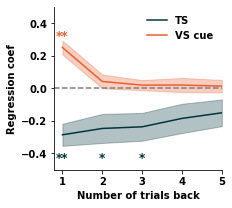

In [378]:
fig, axs = plt.subplots(1,1, figsize=[3,3])
labels = {'tail': 'TS', 'Nacc': 'VS cue'}
for recording_site in ['tail', 'Nacc']:
    mice = change_over_time_mice[recording_site]
    coefs, pvals = regress_previous_choice_same_stim_against_DA(mice)
    plot_multilag_coefs_accross_mice(labels[recording_site], coefs, axs, color=fig4_plotting_colours[recording_site][0])
    makes_plots_pretty(axs)
axs.plot([0.8, 5], [0, 0], ls='--', color='gray')
axs.set_xlim([0.8,5])
axs.xaxis.set_major_locator(MaxNLocator(integer=True))


In [365]:
all_session_data[[f'choice_t_minus_{1}', 'choice']]

,choice_t_minus_1,choice
actual trial nums,,
781.0,NaN,0.0
782.0,0.0,1.0
783.0,1.0,1.0
784.0,1.0,0.0
785.0,0.0,0.0
...,...,...
10237.0,0.0,1.0
10238.0,1.0,0.0
10239.0,0.0,1.0


In [366]:
test_for_coef_trend_against_zero_mulit_lag(coefs)

([5.902299252552355], [0.0010511222928269192])

# Traces for one trial back


In [502]:
def get_photometry_traces_previous_choice_same_stim(mouse, num_lags=5):
    bias_file = os.path.join(bias_path, 'pre_processing_bias_{}.pkl'.format(mouse))
    print('loading{}'.format(mouse))
    all_session_data = pd.read_pickle(bias_file).drop_duplicates(subset='actual trial nums', keep='first').set_index('actual trial nums')

    contra_side = all_session_data[(all_session_data['trial_type'] == 'contra_data') & (all_session_data['First choice correct'] == 1)]['First response'].unique()[0]
    if contra_side == 1:
        ipsi_contra_map = {1: 'contra', 2: 'ipsi'} 
    else:
        ipsi_contra_map = {1: 'ipsi', 2: 'contra'}
    all_session_data['choice'] = all_session_data['First response'].map(ipsi_contra_map)

    # Map 'choice' column to 1 and 0
    all_session_data['choice'] = all_session_data['choice'].map({'contra': 1, 'ipsi': 0})

    for lag in range(1, num_lags + 1):
        df = perform_single_lag_get_traces(all_session_data, lag)

    return df

In [512]:
def perform_single_lag_get_traces(all_session_data, lag):
    all_session_data[f'choice_t_minus_{lag}'] = shift_respecting_index(all_session_data['choice'], lag)
    all_session_data[f'stim_t_minus_{lag}'] = shift_respecting_index(all_session_data['Trial type'], lag)
    all_session_data[f'stim_t_minus{lag}_match'] = (all_session_data[f'stim_t_minus_{lag}'] == all_session_data['Trial type'])
    # Define the dependent variable (dopamine response size)
    test_var = f'choice_t_minus_{lag}'


    contra_trials = all_session_data[(all_session_data['trial_type'] == 'contra_data')
                                     & (all_session_data[f'stim_t_minus{lag}_match'] == True)
                                    & (all_session_data['First choice correct'] == 1)]
    
    
    df = contra_trials[['APE_peaks', 'traces', test_var, 'time_points']].copy()
    df.loc[:, 'APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)
    df = df.dropna()
    return df

In [524]:
def plot_across_mice_traces_side(plotting_vals, axs, site, error_bar_method='sem'):
    for trace_type in plotting_vals:
        mean_trace = plotting_vals[trace_type][0]
        error_bar_lower = plotting_vals[trace_type][1]
        error_bar_upper = plotting_vals[trace_type][2]
        colour_inds = {'contra': 0, 'ipsi': 1}
        site_colours = fig4_plotting_colours[site]
        colour = site_colours[colour_inds[trace_type]]
        time_points = traces_df['time_points'].values[0]
        axs.plot(time_points, mean_trace, lw=1, color=colour, label=trace_type)
        axs.fill_between(time_points, error_bar_lower, error_bar_upper, alpha=0.5,
                                     facecolor=colour, linewidth=0)
    axs.set_ylabel('dLight z-score')
    axs.set_xlabel('Time (s)')
    axs.legend(title='Last choice', frameon=False, fontsize=8, title_fontsize=8)
    makes_plots_pretty(axs)


In [534]:
#fig, axs = plt.subplots(1,1, figsize=[3,3])
all_contra_traces = []
all_ipsi_traces = []
for recording_site in ['Nacc']:
    mice = change_over_time_mice[recording_site]
    for m, mouse in enumerate(mice):
        traces_df = get_photometry_traces_previous_choice_same_stim(mouse, num_lags=1)
        last_choice_contra = traces_df[traces_df['choice_t_minus_1'] == 1]
        last_choice_ipsi = traces_df[traces_df['choice_t_minus_1'] == 0]
        time_points = traces_df['time_points'].values[0]
        contra_mean_trace, _, _ = get_mean_and_sem_traces(last_choice_contra, time_points)
        all_contra_traces.append(contra_mean_trace)
        ipsi_mean_trace, _, _ = get_mean_and_sem_traces(last_choice_ipsi, time_points)
        all_ipsi_traces.append(ipsi_mean_trace)

contra_mean_over_mice_trace, error_bar_lower_c, error_bar_upper_c = get_mean_and_sem_accross_mice_traces(all_contra_traces, time_points)
ipsi_mean_over_mice_trace, error_bar_lower_i, error_bar_upper_i = get_mean_and_sem_accross_mice_traces(all_ipsi_traces, time_points)
plotting_params = {'contra': [contra_mean_over_mice_trace, error_bar_lower_c, error_bar_upper_c],
                  'ipsi': [ipsi_mean_over_mice_trace, error_bar_lower_i, error_bar_upper_i]}


loadingSNL_photo28
loadingSNL_photo30
loadingSNL_photo31
loadingSNL_photo32
loadingSNL_photo33
loadingSNL_photo34
loadingSNL_photo35


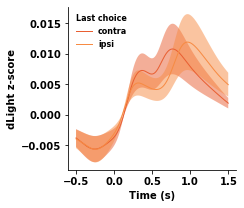

In [535]:
fig, axs = plt.subplots(1,1, figsize=[3,3])
plot_across_mice_traces_side(plotting_params, axs, recording_site)

In [ ]:
def get_mean_and_sem_accross_mice_traces(all_mean_traces, time_points, error_bar_method='sem'):
    array_traces = np.zeros([traces_df.shape[0], time_points.shape[0]])
    for i, trace in enumerate(all_mean_traces):
        array_traces[i, :] = all_mean_traces[i]
    mean_trace = array_traces.mean(axis=0)
    error_bar_lower, error_bar_upper = calculate_error_bars(mean_trace,
                                                                    array_traces,
                                                                    error_bar_method=error_bar_method)
    return mean_trace, error_bar_lower, error_bar_upper

In [505]:
def get_mean_and_sem_traces(traces_df, time_points, error_bar_method='sem'):
    array_traces = np.zeros([traces_df.shape[0], time_points.shape[0]])
    r=0
    for _, row in traces_df.iterrows():
        array_traces[r, :] = row.traces
        r+=1
    mean_trace = array_traces.mean(axis=0)
    error_bar_lower, error_bar_upper = calculate_error_bars(mean_trace,
                                                                    array_traces,
                                                                    error_bar_method=error_bar_method)
    return mean_trace, error_bar_lower, error_bar_upper

def plot_example_mouse_traces_side(traces_df, trace_type, axs, site, error_bar_method='sem'):
    colour_inds = {'contra': 0, 'ipsi': 1}
    site_colours = fig4_plotting_colours[site]
    colour = site_colours[colour_inds[trace_type]]
    time_points = traces_df['time_points'].values[0]
    mean_trace, error_bar_lower, error_bar_upper = get_mean_and_sem_traces(traces_df, time_points)
    axs.plot(time_points, mean_trace, lw=1, color=colour, label=trace_type)
    axs.fill_between(time_points, error_bar_lower, error_bar_upper, alpha=0.5,
                                 facecolor=colour, linewidth=0)
    axs.set_ylabel('dLight z-score')
    axs.set_xlabel('Time (s)')
    axs.legend(title='Last choice', frameon=False, fontsize=8, title_fontsize=8)
    makes_plots_pretty(axs)


loadingSNL_photo17


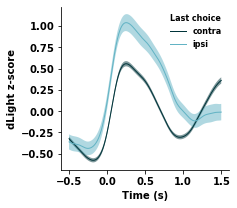

In [513]:
# Example mouse
mouse = 'SNL_photo17'
site = 'tail'
traces_df = get_photometry_traces_previous_choice_same_stim(mouse, num_lags=1)
last_choice_contra = traces_df[traces_df['choice_t_minus_1'] == 1]
last_choice_ipsi = traces_df[traces_df['choice_t_minus_1'] == 0]
fig, axs = plt.subplots(1,1, figsize=[3,3])
plot_example_mouse_traces_side(last_choice_contra, 'contra', axs, site)
plot_example_mouse_traces_side(last_choice_ipsi, 'ipsi', axs, site)

loadingSNL_photo33


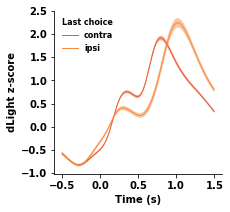

In [533]:
# Example mouse
site = 'Nacc'
mouse = change_over_time_mice[site][4]
traces_df = get_photometry_traces_previous_choice_same_stim(mouse, num_lags=1)
last_choice_contra = traces_df[traces_df['choice_t_minus_1'] == 1]
last_choice_ipsi = traces_df[traces_df['choice_t_minus_1'] == 0]
fig, axs = plt.subplots(1,1, figsize=[3,3])
plot_example_mouse_traces_side(last_choice_contra, 'contra', axs, site)
plot_example_mouse_traces_side(last_choice_ipsi, 'ipsi', axs, site)